In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

import json

try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 0


In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

# Data loading
def data_to_df(job_run, samp_num):
    file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{job_run}/dataJob1ifile{samp_num}.root'
    data_file = uproot.open(file_name)
    data_array = data_file['tree'].arrays()
    data_df = pd.DataFrame(data_array)
    return data_df

In [3]:
# Load full data
data_2018_full_dfs = []
for i in range(946):
    data_2018_full_dfs.append(data_to_df('job_1_ntuple20180805v1', i))
data_2018_full_df = pd.concat(data_2018_full_dfs, ignore_index=True)

data_2017_full_dfs = []
for i in range(261):
    data_2017_full_dfs.append(data_to_df('job_1_ntuple20170805v1', i))
data_2017_full_df = pd.concat(data_2017_full_dfs, ignore_index=True)

data_2016_full_dfs = []
for i in range(384):
    data_2016_full_dfs.append(data_to_df('job_1_ntuple20160805v1', i))
data_2016_full_df = pd.concat(data_2016_full_dfs, ignore_index=True)

In [37]:
import json

# Good luminosity functions

def convert_json_txt_to_dict(file_name):
    with open(file_name) as file:
        data = file.read()
    return json.loads(data)

def good_lumi_list(data_df, good_lumi_dict):
    good_lumis = []
    for index, row in data_df.iterrows():
        run = row[b'run']
        lumi = row[b'lumi']
        good_lumi = 0
        if str(int(run)) in good_lumi_dict:
            lumi_blocks = good_lumi_dict[str(int(run))]
            for lumi_block in lumi_blocks:
                if lumi_block[0] <= lumi and lumi <= lumi_block[1]:
                    good_lumi = 1
                    break
        good_lumis.append(good_lumi)
    return good_lumis


# Get good luminosity dictionaries

Good_Lum_2018 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt')
Good_Lum_2017 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_294927-306462_13TeV_EOY2017ReReco_Collisions17_JSON_v1.txt')
Good_Lum_2016 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_271036-284044_13TeV_ReReco_07Aug2017_Collisions16_JSON.txt')

# Good luminosity selection

data_2018_full_df[b'good_lumi'] = good_lumi_list(data_2018_full_df, Good_Lum_2018)
data_2018_good_df = data_2018_full_df[data_2018_full_df[b'good_lumi'] == 1]

data_2017_full_df[b'good_lumi'] = good_lumi_list(data_2017_full_df, Good_Lum_2017)
data_2017_good_df = data_2017_full_df[data_2017_full_df[b'good_lumi'] == 1]

data_2016_full_df[b'good_lumi'] = good_lumi_list(data_2016_full_df, Good_Lum_2016)
data_2016_good_df = data_2016_full_df[data_2016_full_df[b'good_lumi'] == 1]

data_full_df = pd.concat([data_2018_full_df, data_2017_full_df, data_2016_full_df], ignore_index=True)

data_full_df_1 = data_full_df[data_full_df[b'diphoton_mass']>135]
data_full_df_2 = data_full_df[data_full_df[b'diphoton_mass']<115]
data_full_df_wind = pd.concat([data_full_df_1, data_full_df_2], ignore_index=True)

In [38]:
GluGluToHH_df_2018 = samp_to_df('job_5_ntuple20180805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job5ifile', 0)
GluGluToHH_df_2017 = samp_to_df('job_8_ntuple20170805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job8ifile', 15)
GluGluToHH_df_2016 = samp_to_df('job_8_ntuple20160805v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job8ifile', 3)
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)

In [6]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'leading_bjet_pt_over_dimass', b'leading_bjet_pt_over_dimass_corr'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [39]:
path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'


names = ['TTG Jets', 'TTGG_0Jets', 'TTJets', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox', 'QCD_Jets']

sig_frame_all = GluGluToHH_df
bkg_frame_all = data_full_df_wind.drop(axis=1, columns =[b'good_lumi'])

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]


sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [40]:
bkg_frame_all.head()

,b'run',b'lumi',b'event',b'trig_decision',b'pv_pass',b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'fatJetPt',b'fatJetEta',b'fatJetPhi',b'fatJetMassSD_UnCorrected',b'fatJetbtagDDBvL'
0,315801,89,91094387,1,1,92.063103,-1.227051,2.780273,42.311184,0.087067,...,0.994629,1.994141,0.589443,2.716135,1.685364,-999.0,-999.0,-999.0,-999.0,-999.0
1,315801,169,170221697,1,1,85.579910,-1.138672,-0.582275,53.044937,-2.199219,...,0.061829,0.175964,0.572546,1.128323,1.045545,-999.0,-999.0,-999.0,-999.0,-999.0
2,316569,1902,2655106482,1,1,107.546097,0.561157,3.032227,74.147636,0.751709,...,0.019318,0.054871,0.634470,0.552113,0.547684,-999.0,-999.0,-999.0,-999.0,-999.0
3,316590,59,66121898,1,1,83.010948,0.726074,-1.572998,53.931732,-0.297974,...,0.035065,0.074677,0.586467,0.539734,0.674995,-999.0,-999.0,-999.0,-999.0,-999.0
4,316590,59,65700481,1,1,97.503487,0.291443,2.255859,63.559029,0.238739,...,0.296631,0.315292,0.651410,0.661457,0.597724,-999.0,-999.0,-999.0,-999.0,-999.0


In [29]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,145.241119,0.918335,0.491089,75.707062,0.319824,1.547607,142.2500,2.209473,-2.042480,28.140625,...,0.074707,0.050354,0.125061,1.176838,0.753909,0.984135,0.000028,188.683197,123.416451,112008
1,81.548317,-0.114059,2.528809,68.587204,-0.079712,0.564209,80.1250,-1.288086,-0.381775,60.750000,...,0.039551,0.964844,1.004395,0.655325,0.715544,0.747966,-0.000028,111.977684,124.439453,112017
2,109.037231,-0.835327,1.176514,87.997322,-0.765747,2.546875,115.9375,-1.357910,-1.699951,69.312500,...,0.331299,0.424072,0.755371,0.878197,1.041834,1.011527,0.000028,111.282120,124.160385,112010
3,99.698898,-0.390930,-0.474426,54.716755,-0.526611,1.511963,92.5625,0.323792,2.379883,26.750000,...,0.189087,0.656250,0.845337,0.802983,0.870629,0.821134,0.000028,106.316811,124.160637,112001
4,78.673645,2.106934,-1.360596,74.914726,1.376465,0.152924,178.5000,1.395996,2.549316,31.062500,...,0.998047,0.077209,1.075256,0.655613,1.426055,1.441129,0.000028,125.170486,120.000145,112006


In [15]:
bkg_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'leadingDeepBscore',b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,92.063103,-1.227051,2.780273,42.311184,0.087067,2.445312,155.3750,-0.328064,-0.237305,43.750000,...,0.999512,0.994629,1.994141,0.589443,2.716135,1.685364,1.0,57.204453,156.186508,91094387
1,85.579910,-1.138672,-0.582275,53.044937,-2.199219,3.125977,76.3125,-1.513428,0.748291,33.093750,...,0.114136,0.061829,0.175964,0.572546,1.128323,1.045545,1.0,67.633553,149.472626,170221697
2,107.546097,0.561157,3.032227,74.147636,0.751709,-0.780151,83.5000,-0.025852,-0.277710,47.312500,...,0.035553,0.019318,0.054871,0.634470,0.552113,0.547684,1.0,151.237228,169.505341,2655106482
3,83.010948,0.726074,-1.572998,53.931732,-0.297974,0.726318,91.6250,-1.269287,-2.771484,30.515625,...,0.039612,0.035065,0.074677,0.586467,0.539734,0.674995,1.0,169.759399,141.544144,66121898
4,97.503487,0.291443,2.255859,63.559029,0.238739,-1.518799,98.1250,-0.728760,-0.431396,51.468750,...,0.018661,0.296631,0.315292,0.651410,0.661457,0.597724,1.0,148.346741,149.680664,65700481


In [41]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [42]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [43]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    #x_full_test = data_full[test_index] # full df test portion

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

TRAIN: [     1      2      3 ... 470682 470683 470686] TEST: [     0      5      6 ... 470664 470684 470685]
TRAIN: [     0      1      2 ... 470682 470684 470685] TEST: [     3     12     13 ... 470678 470683 470686]
TRAIN: [     0      1      2 ... 470684 470685 470686] TEST: [    11     15     35 ... 470671 470675 470679]
TRAIN: [     0      1      2 ... 470684 470685 470686] TEST: [     4      8     21 ... 470653 470660 470668]
TRAIN: [     0      3      4 ... 470684 470685 470686] TEST: [     1      2      7 ... 470680 470681 470682]
(376550, 18)
(376550,)
(94137, 18)
(94137,)


In [44]:
sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_test == 1]
bgd_test_weights = test_weight[y_test == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

In [45]:
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               1900      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [46]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/data/data_mass_model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2783 - accuracy: 0.8851 - val_loss: 0.0776 - val_accuracy: 0.9781
Epoch 2/50
2009/2009 [==============================] - 4s 2ms/step - loss: 0.1071 - accuracy: 0.9640 - val_loss: 0.0225 - val_accuracy: 0.9980
Epoch 3/50
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0679 - accuracy: 0.9773 - val_loss: 0.0187 - val_accuracy: 0.9993
Epoch 4/50
2009/2009 [==============================] - 5s 2ms/step - loss: 0.0580 - accuracy: 0.9800 - val_loss: 0.0153 - val_accuracy: 0.9990
Epoch 5/50
2009/2009 [==============================] - 5s 2ms/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 0.0186 - val_accuracy: 0.9999
Epoch 6/50
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0500 - accuracy: 0.9825 - val_loss: 0.0203 - val_accuracy: 0.9993
Epoch 7/50
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0484 - accuracy: 0.9834 - val_loss: 0.0142 - val_accuracy:

2021-08-13 01:22:53.786754: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [47]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

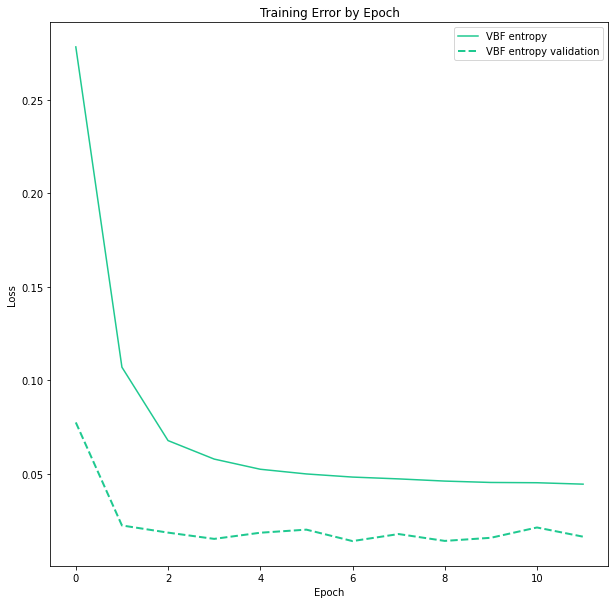

In [48]:
show_losses( [("VBF entropy", hist)])

In [49]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

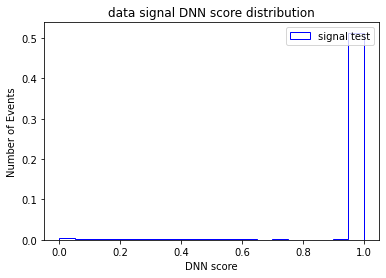

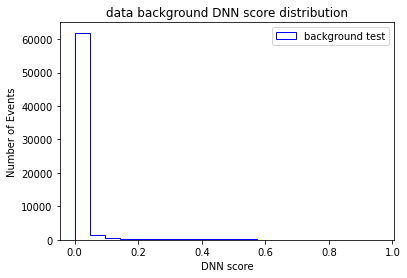

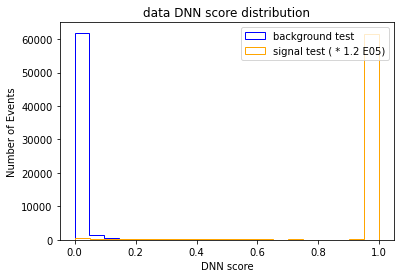

In [50]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title('data signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('data background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.hist(sgl, color='orange', weights= 120000 * sgl_weight, histtype='step', bins = 20, label= 'signal test ( * 1.2 E05)')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title('data DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_score.png', format='png')
plt.show()

In [51]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'DNN score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'DNN score'] = bgd_y

In [52]:
# make copy of dataframe

result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values

In [53]:
result_sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,61.509430,2.248535,-2.441406,59.101131,0.842651,-0.969238,91.5000,1.409424,0.769775,57.00000,...,0.999512,1.945801,0.502155,0.830068,0.830786,0.000016,110.231934,122.490967,130812.0,0.999778
1,86.224060,-0.243652,-1.339355,66.972511,-1.683105,-1.646484,90.9375,-1.701416,1.482666,42.40625,...,0.994629,1.060791,0.710687,0.780095,0.763685,0.000028,116.572380,121.325027,129460.0,0.999950
2,153.583817,-0.568237,2.524902,40.134926,0.854126,2.211914,209.8750,-1.322266,-0.768799,70.06250,...,0.867676,1.861328,1.240879,2.143149,2.049539,0.000019,97.928314,123.770210,171961.0,0.999970
3,86.939980,-2.224609,0.384705,61.831142,-1.189697,-0.911377,131.0000,-1.161621,2.838379,49.84375,...,0.912109,0.993652,0.731524,1.042778,1.087120,0.000028,125.626007,118.847672,129187.0,0.999667
4,116.334915,-0.661377,-2.950684,32.280910,-2.312988,2.449707,139.6250,-1.060791,-0.058052,33.50000,...,0.013847,0.955254,0.933325,2.059712,2.121202,0.000019,67.788589,124.645729,52571.0,0.999941


In [54]:
result_bgd_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,43.862011,1.117676,-0.483643,37.339962,-1.059082,-0.641357,55.9375,-0.160645,2.562500,28.562500,...,0.145386,0.239807,0.410942,0.464226,0.760048,1.0,120.496208,106.735268,1.157913e+09,0.000274
1,56.203487,0.304871,2.158203,51.070694,-0.021641,-0.246643,49.8125,0.222534,-1.908691,29.265625,...,-2.000000,-1.970520,0.553753,0.677898,0.656769,1.0,73.480865,101.495506,5.180736e+07,0.000310
2,65.343903,0.442444,0.471863,43.819344,-0.589111,-1.825684,83.8750,-0.483521,1.267578,35.031250,...,0.999512,1.998047,0.576248,0.786107,0.782927,1.0,106.696724,113.395470,4.496152e+08,0.168180
3,93.375107,0.287109,-0.668335,44.823936,1.372314,0.250244,34.2500,-0.533447,1.419922,26.953125,...,0.115417,0.130203,0.525041,0.291209,0.430028,1.0,117.613159,177.843475,4.208494e+07,0.000445
4,41.963192,0.147156,1.603516,30.601486,2.214844,-2.770508,45.8125,0.881958,1.082275,42.218750,...,0.030426,0.052902,0.397083,0.492126,0.493480,1.0,93.090950,105.678719,2.060218e+08,0.000274


In [56]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/data/data_sig_DNN_file.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/data/data_bgd_DNN_file.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x5f6789c0>

In [57]:
file_name = f'DNN_Trees/data/data_sig_DNN_file.root'
data_file = uproot.open(file_name)
data_array = data_file['tree'].arrays()
data_df = pd.DataFrame(data_array)
data_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',...,b'subleadingDeepBscore',b'sumDeepBscore',b'leading_pho_pt_over_dimass',b'leading_bjet_pt_over_dimass',b'leading_bjet_pt_over_dimass_corr',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN score'
0,61.509430,2.248535,-2.441406,59.101131,0.842651,-0.969238,91.5000,1.409424,0.769775,57.00000,...,0.999512,1.945801,0.502155,0.830068,0.830786,0.000016,110.231934,122.490967,130812.0,0.999778
1,86.224060,-0.243652,-1.339355,66.972511,-1.683105,-1.646484,90.9375,-1.701416,1.482666,42.40625,...,0.994629,1.060791,0.710687,0.780095,0.763685,0.000028,116.572380,121.325027,129460.0,0.999950
2,153.583817,-0.568237,2.524902,40.134926,0.854126,2.211914,209.8750,-1.322266,-0.768799,70.06250,...,0.867676,1.861328,1.240879,2.143149,2.049539,0.000019,97.928314,123.770210,171961.0,0.999970
3,86.939980,-2.224609,0.384705,61.831142,-1.189697,-0.911377,131.0000,-1.161621,2.838379,49.84375,...,0.912109,0.993652,0.731524,1.042778,1.087120,0.000028,125.626007,118.847672,129187.0,0.999667
4,116.334915,-0.661377,-2.950684,32.280910,-2.312988,2.449707,139.6250,-1.060791,-0.058052,33.50000,...,0.013847,0.955254,0.933325,2.059712,2.121202,0.000019,67.788589,124.645729,52571.0,0.999941


In [58]:
# Bkg reduction
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

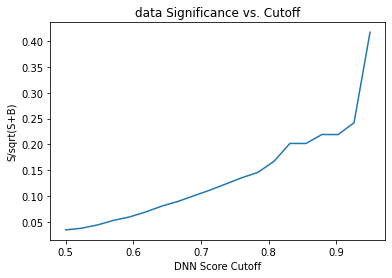

In [65]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/data/data_mass_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = 'data')
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/sqrt(S+B)')
plt.title('data Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_significance.png', format='png')
plt.show()

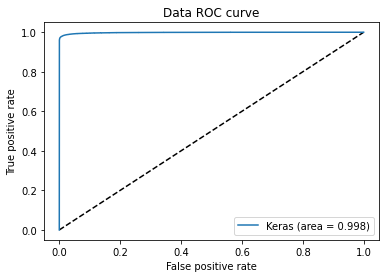

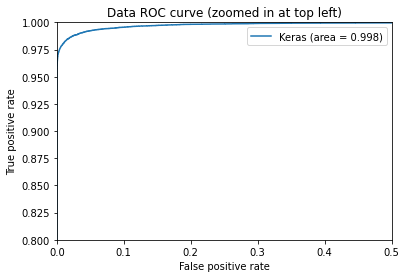

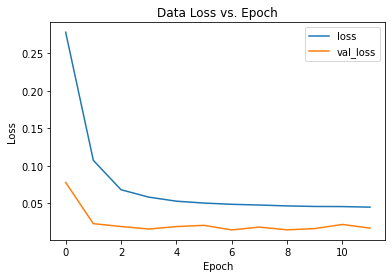

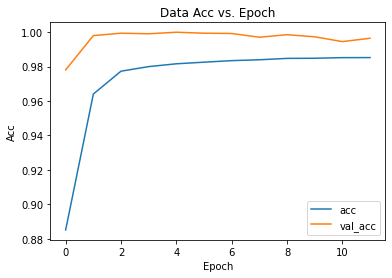

In [60]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Data ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_mass_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('Data ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_mass_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Data Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_mass_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Data Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_mass_acc_epoch.png', format='png')
plt.show()

In [61]:
file = open('Efficiency/data/data_mass_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [62]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure()
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=fontsize)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('data '+samples[label])
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_mass_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure()
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=12)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('data '+samples[label])
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_mass_jj_mass_sculpt_{samples[label]}')

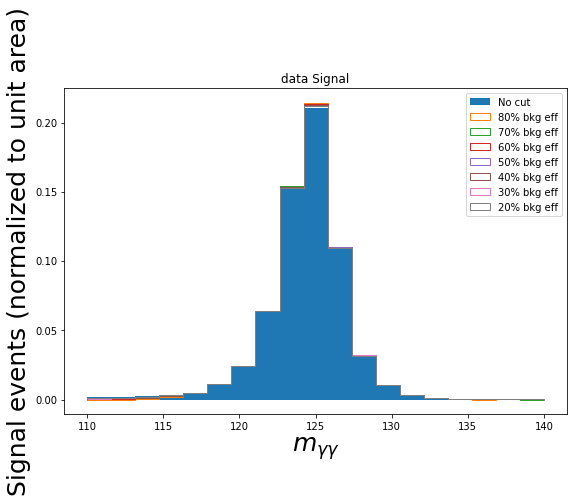

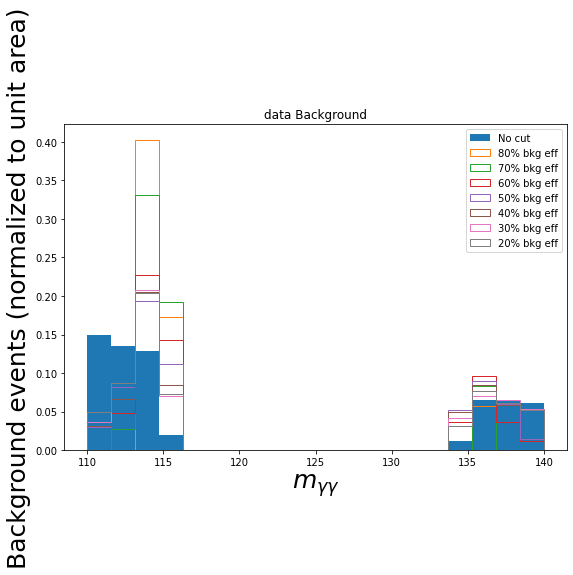

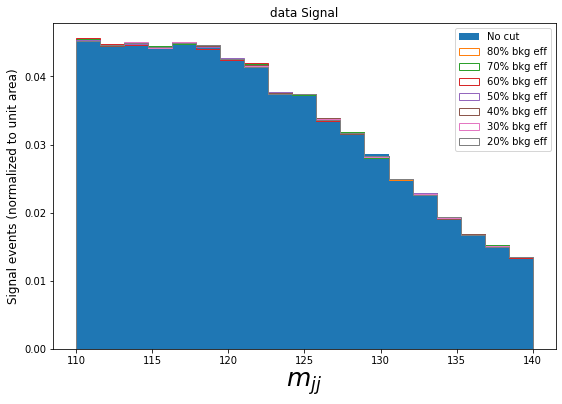

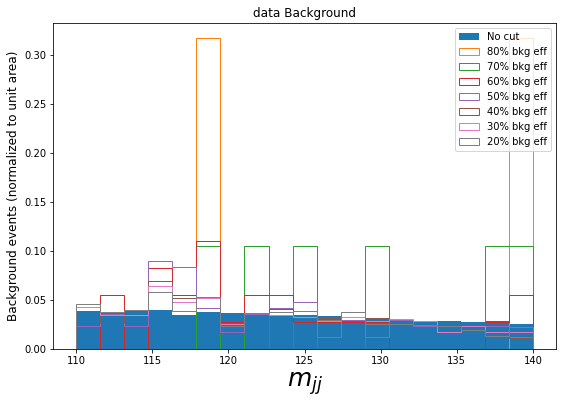

In [63]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 20, 18, 22, 23)
#bkg
check_mass_gg(0, test_all, 20, 18, 22, 23)

#signal
check_mass_jj(1, test_all, 19, 18, 22, 23)
#bkg
check_mass_jj(0, test_all, 19, 18, 22, 23)

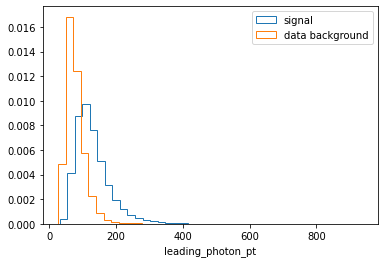

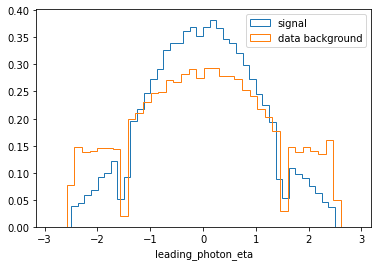

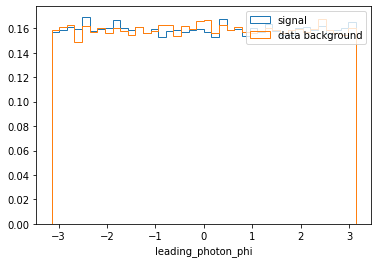

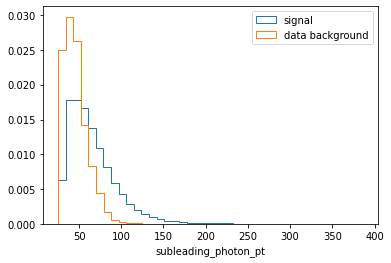

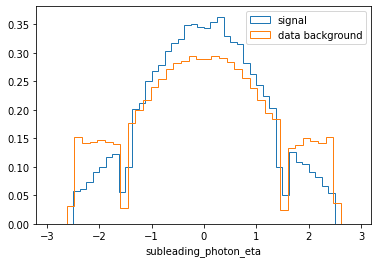

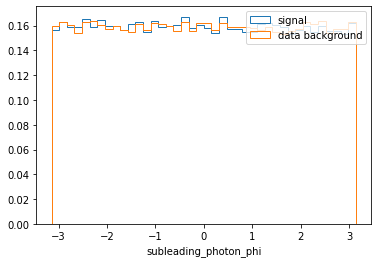

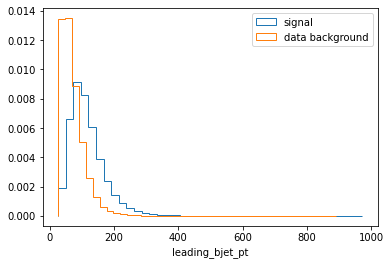

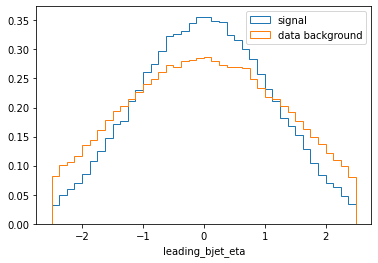

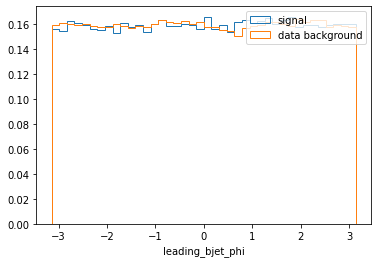

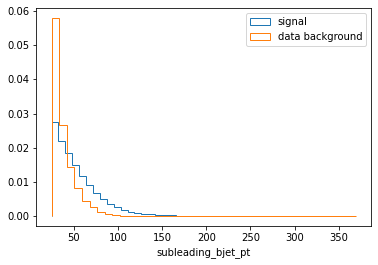

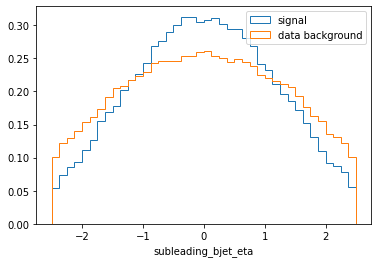

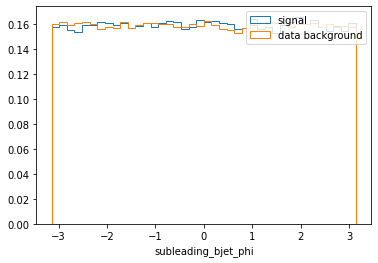

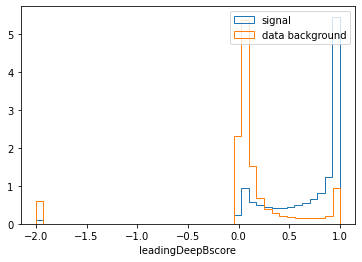

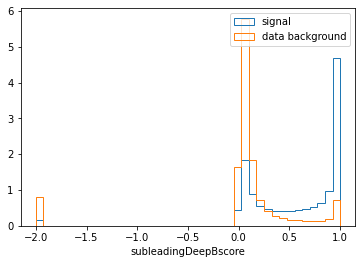

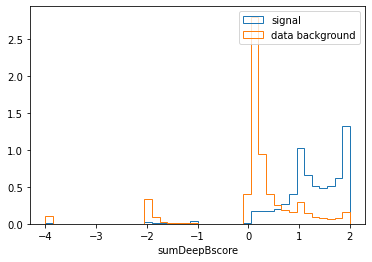

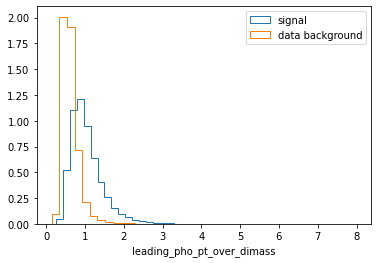

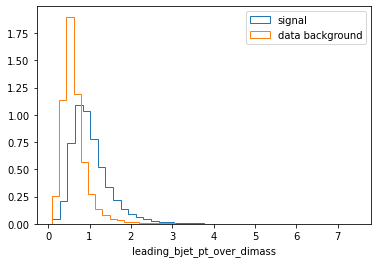

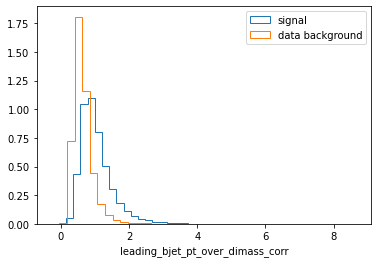

In [64]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= 'data background')
    plt.xlabel(hlf.decode("utf-8"))
    plt.savefig(fname = f'BackgroundVsSignal_Plts/data/data_{hlf}')
    plt.legend(loc='best')

# 